# Modelling lithium plating in PyBaMM

This notebook shows how PyBaMM [8] can be used to model both reversible and irreversible lithium plating.

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import os

import pybamm

os.chdir(pybamm.__path__[0] + "/..")

Note: you may need to restart the kernel to use updated packages.


The Doyle-Fuller-Newman model [3] is upgraded with three different lithium plating models. Model 1 contains the reversible lithium plating model of O'Kane et al. [5]. Model 2 contains the same model but with the lithium stripping capability removed, making the plating irreversible. Model 3 contains the updated partially reversible plating of O'Kane et al. [6]. The parameters are taken from Chen et al.'s investigation [2] of an LG M50 cell.

In [2]:
# choose models
plating_options = ["reversible", "irreversible", "partially reversible"]
models = {
    option: pybamm.lithium_ion.DFN(options={"lithium plating": option}, name=option)
    for option in plating_options
}

# pick parameters
parameter_values = pybamm.ParameterValues("OKane2022")
parameter_values.update({"Ambient temperature [K]": 268.15})
parameter_values.update({"Upper voltage cut-off [V]": 4.21})
# parameter_values.update({"Lithium plating kinetic rate constant [m.s-1]": 1E-9})
parameter_values.update({"Lithium plating transfer coefficient": 0.5})
parameter_values.update({"Dead lithium decay constant [s-1]": 1e-4})

A series of simple fast charging experiments based on those of Ren et al. [7] is defined here. We first initialise the model at 0% SoC by performing a C/20 discharge (see more details on how to initialise a model from a simulation in [this notebook](../initialize-model-with-solution.ipynb)).

In [3]:
# specify experiments
pybamm.citations.register("Ren2018")

s = pybamm.step.string
experiment_discharge = pybamm.Experiment(
    [
        (
            s("Discharge at C/20 until 2.5 V"),
            s("Rest for 1 hour"),
        ),
    ]
)

sims_discharge = []
for model in models.values():
    # we need to adjust the tolerances to get a good solution for the partially reversible case
    solver = pybamm.IDAKLUSolver(atol=1e-5, rtol=1e-5)
    sim_discharge = pybamm.Simulation(
        model,
        parameter_values=parameter_values,
        experiment=experiment_discharge,
        solver=solver,
    )
    sol_discharge = sim_discharge.solve(calc_esoh=False)
    model.set_initial_conditions_from(sol_discharge, inplace=True)
    sims_discharge.append(sim_discharge)

And we can now define the different experiments to charge at different C-rates.

In [4]:
C_rates = ["2C", "1C", "C/2", "C/4", "C/8"]
experiments = {}
for C_rate in C_rates:
    experiments[C_rate] = pybamm.Experiment(
        [
            (
                f"Charge at {C_rate} until 4.2 V",
                "Hold at 4.2 V until C/20",
                "Rest for 1 hour",
            )
        ]
    )

Solve the reversible plating model first.

In [5]:
def define_and_solve_sims(model, experiments, parameter_values):
    sims = {}
    for C_rate, experiment in experiments.items():
        sim = pybamm.Simulation(
            model, experiment=experiment, parameter_values=parameter_values
        )
        sim.solve(calc_esoh=False)
        sims[C_rate] = sim

    return sims


sims_reversible = define_and_solve_sims(
    models["partially reversible"], experiments, parameter_values
)

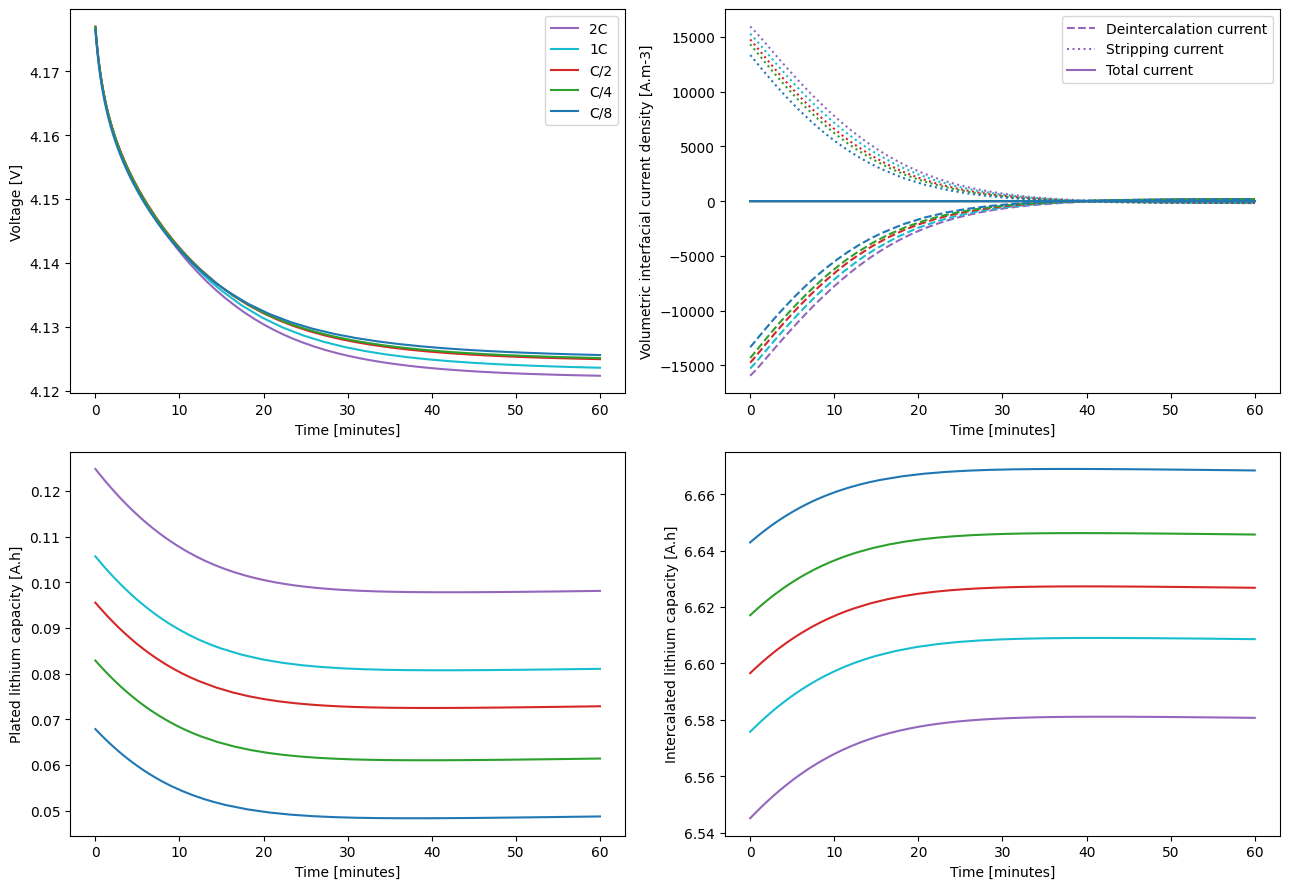

In [6]:
colors = ["tab:purple", "tab:cyan", "tab:red", "tab:green", "tab:blue"]
linestyles = ["dashed", "dotted", "solid"]

param = models["reversible"].param
A = parameter_values.evaluate(param.L_y * param.L_z)
F = parameter_values.evaluate(param.F)
L_n = parameter_values.evaluate(param.n.L)

currents = [
    "X-averaged negative electrode volumetric interfacial current density [A.m-3]",
    "X-averaged negative electrode lithium plating volumetric interfacial current density [A.m-3]",
    "Sum of x-averaged negative electrode volumetric interfacial current densities [A.m-3]",
]


def plot(sims):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2, 2, figsize=(13, 9))
    for (C_rate, sim), color in zip(sims.items(), colors, strict=False):
        # Isolate final equilibration phase
        sol = sim.solution.cycles[0].steps[2]

        # Voltage vs time
        t = sol["Time [min]"].entries
        t = t - t[0]
        V = sol["Voltage [V]"].entries
        axs[0, 0].plot(t, V, color=color, linestyle="solid", label=C_rate)

        # Currents
        for current, ls in zip(currents, linestyles, strict=False):
            j = sol[current].entries
            axs[0, 1].plot(t, j, color=color, linestyle=ls)

        # Plated lithium capacity
        Q_Li = sol["Loss of capacity to negative lithium plating [A.h]"].entries
        axs[1, 0].plot(t, Q_Li, color=color, linestyle="solid")

        # Capacity vs time
        Q_main = (
            sol["Negative electrode volume-averaged concentration [mol.m-3]"].entries
            * F
            * A
            * L_n
            / 3600
        )
        axs[1, 1].plot(t, Q_main, color=color, linestyle="solid")

    axs[0, 0].legend()
    axs[0, 0].set_ylabel("Voltage [V]")
    axs[0, 1].set_ylabel("Volumetric interfacial current density [A.m-3]")
    axs[0, 1].legend(("Deintercalation current", "Stripping current", "Total current"))
    axs[1, 0].set_ylabel("Plated lithium capacity [A.h]")
    axs[1, 1].set_ylabel("Intercalated lithium capacity [A.h]")

    for ax in axs.flat:
        ax.set_xlabel("Time [minutes]")

    fig.tight_layout()

    return fig, axs


plot(sims_reversible);

The results show both similarities and differences with those of Ren et al. [7]. Notably, unlike Ren et al., this model uses equations [5] that result in a small but finite amount of plated lithium being present in the steady state.

Now solve the irreversible plating model and see how it compares.

In [7]:
sims_irreversible = define_and_solve_sims(
    models["irreversible"], experiments, parameter_values
)

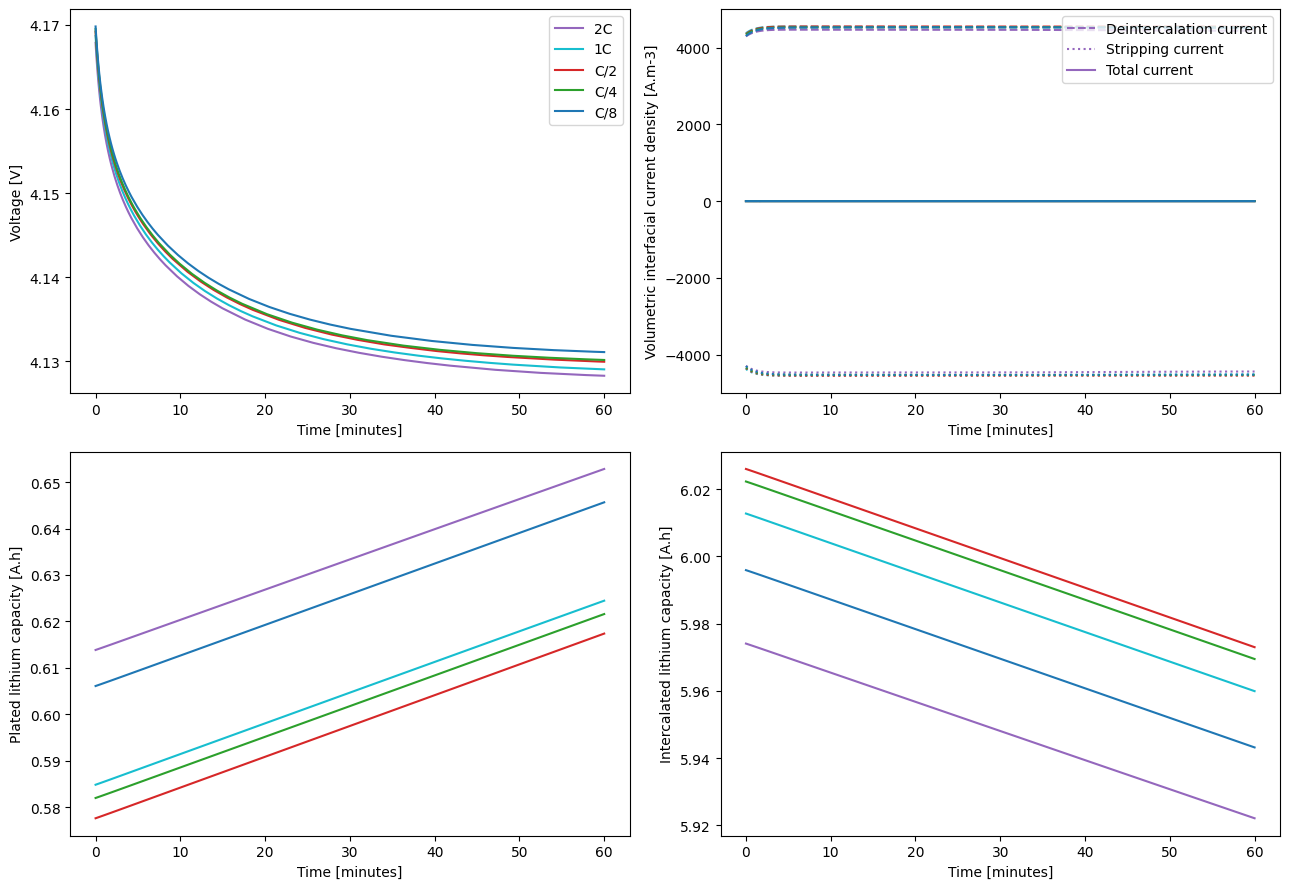

In [8]:
plot(sims_irreversible);

Unlike in the reversible case, there is no steady state and the capacity degrades quickly. The lithium inventory decreases by around 40 mAh in just an hour, which is unrealistic. The low temperature fast charge simulations are run one more time, with the partially reversible plating model.

In [9]:
sims_partially_reversible = define_and_solve_sims(
    models["partially reversible"], experiments, parameter_values
)

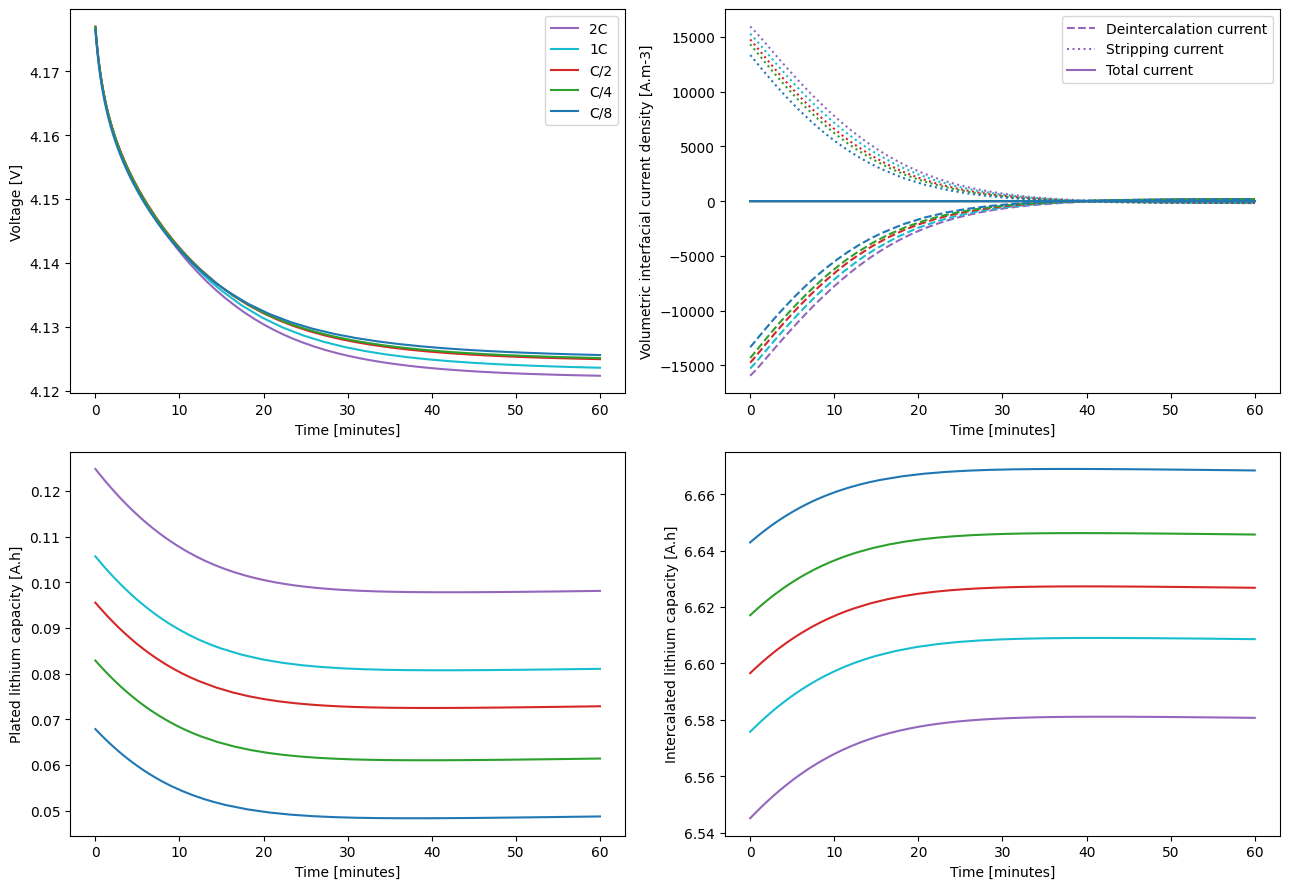

In [10]:
plot(sims_partially_reversible);

The partially reversible plating model has features of both the reversible and irreversible models, which is reflected in the results. The plated lithium capacity decreases with time as lithium is reversibly stripped, but the final plated lithium capacity now depends on charge rate, indicating that some lithium was irreversibly plated during charge.

# References

In [11]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[3] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[4] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. 